In [17]:
import torch  # PyTorchの基本的な機能を含むメインのライブラリ
import torch.nn as nn  # ニューラルネットワークの構築に関連するクラスや関数を含むモジュール
import torch.optim as optim  # 最適化アルゴリズムを含むモジュール
import torchvision  # 一般的なデータセットや事前学習モデルなど、コンピュータビジョンに関するユーティリティを提供
import torchvision.transforms as transforms  # 画像の前処理に関連するクラスや関数を含むモジュール
from torchvision import models  # 事前学習済みモデルや一般的なモデルアーキテクチャを含むモジュール
from torchvision.datasets import ImageFolder # ディレクトリ構造から画像データセットをロードするためのクラス
from torch.utils.data import DataLoader, random_split  # データセットのローディングや分割に関連するユーティリティ

In [18]:
import mlflow

mlflow.start_run()
run = mlflow.active_run()
print(f"Active run_id: {run.info.run_id}")
mlflow.end_run()

Active run_id: 940dffef7a924e8994e8f5bd83f0508e


In [19]:
import mlflow
import mlflow.pytorch

# ハイパーパラメータの設定
BATCH_SIZE = 8
OPTIMIZER = optim.SGD
EPOCHES = 20
add = 'model3-2'

# mlflowの実験名の設定
EXP_NAME = "final"
RUN_NAME = "resnet_"+str(BATCH_SIZE)+"_"+str(OPTIMIZER)+"_"+ add
mlflow.set_experiment(EXP_NAME)

<Experiment: artifact_location='mlflow-artifacts:/704062868771128137', creation_time=1699279199842, experiment_id='704062868771128137', last_update_time=1699279199842, lifecycle_stage='active', name='final', tags={}>

In [20]:
# ブロック2-6
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # 画像をランダムに水平反転
    transforms.RandomRotation(10),             # 画像を-10〜10度の範囲でランダムに回転
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 色のバリエーションをランダムに変更
    transforms.Resize([224,224]),  # 画像のサイズを224x224ピクセルにリサイズ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
# ブロック 3-2
dataset_path = "./Dataset/Dataset3-2/"  # あなたのデータセットへのパスに変更してください
dataset = ImageFolder(root=dataset_path, transform=data_transforms)

In [22]:
# ブロック 4-2
train_size = int(0.7 * len(dataset))  # 70%を訓練データに
val_size = int(0.2 * len(dataset)) # 15%を検証データに
test_size = len(dataset) - train_size - val_size # 残り15%をテストデータに

# 与えられたサイズに基づいてデータセットをランダムに分割
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader =  DataLoader(test_dataset,  shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

389
56


In [23]:
# ブロック 5-1
device = torch.device('mps')
device # deviceが何に設定されたかを確認

device(type='mps')

ミニバッチサイズ： 8
チャネル数： 3
画像の高さ： 224
画像の幅　： 224
torch.Size([8, 3, 224, 224])


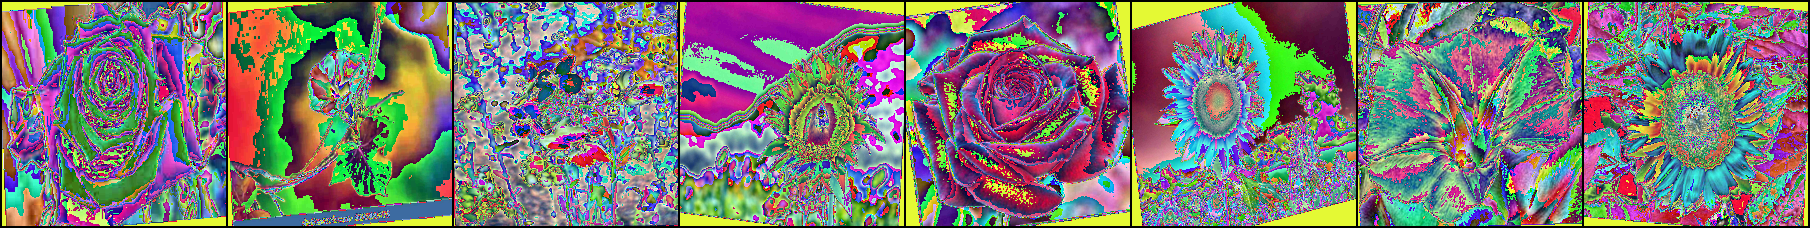

In [24]:
# ブロック 6
imgs, _ = next(iter(train_loader))
c, h, w = imgs[0].shape
print("ミニバッチサイズ：", len(imgs))
print("チャネル数：", c)
print("画像の高さ：", h)
print("画像の幅　：", w)
print(imgs.shape)

# グリッド上に並べて1枚の画像にする
img = torchvision.utils.make_grid(imgs)
img = transforms.functional.to_pil_image(img)
display(img)

In [25]:
# ブロック 7-1-2
NUM_CLASSES = 9 # 分類するクラス数を設定　この値を自分のタスクに合わせｆｆて設定すること

# 例）ResNetの学習済みモデルを利用する場合
# 転移学習の例
model = models.resnet152(weights='DEFAULT')

# 全ての層のパラメータを訓練不可に
for param in model.parameters():
    param.requires_grad = False

# 最後の全結合層をNUM_CLASSES分類用に変更
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
# ViT base パッチ数16の学習済みモデルを利用
# model = models.vit_b_16(weights='DEFAULT')

# # 全ての層のパラメータを訓練不可に
# for param in model.parameters():
#     param.requires_grad = False

# # 最後の全結合層をNUM_CLASSES分類用に変更
# num_ftrs = model.heads[0].in_features
# model.heads[0] = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [26]:
# ブロック 8
# 多クラス分類（2値分類も含む）のための損失関数の使用準備
criterion = nn.CrossEntropyLoss()

In [27]:
# AdamなどSGD以外の最適化関数を使用する場合
# optimizer = OPTIMIZER(model.parameters(), lr=0.001)
# 例）過学習を抑制する場合
#optimizer = OPTIMIZER(model.parameters(),lr=0.001 weight_decay=5e-4)

# SGDを使用する場合
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [28]:
# mlflowのトラッキング開始
with mlflow.start_run():

    train_losses = []
    val_losses = []

    # ハイパーパラメータを記録
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("optimizer", OPTIMIZER)
    mlflow.log_param("epochs", EPOCHES)

    # RUN Timeの名前を設定
    mlflow.set_tag("mlflow.runName", RUN_NAME)  # runの名前をタグとして設定

    for epoch in range(EPOCHES):
        # モデルを訓練モードに設定
        model.train()
        total_loss = 0.0
        # 訓練データをミニバッチごとに処理
        for i, (images, labels) in enumerate(train_loader):
            # データをGPU等のデバイスに移動
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) # モデルに画像を入力し、予測値を取得
            loss = criterion(outputs, labels) # 損失を計算       
            optimizer.zero_grad() # 勾配を初期化
            loss.backward()  # バックプロパゲーションを実行        
            optimizer.step() # 重みの更新        
            total_loss += loss.item() # 現在のバッチの損失を累積値に追加

            # 平均訓練損失を計算
            avg_train_loss = total_loss / len(train_loader)
            train_losses.append(avg_train_loss)

        # モデルを評価モードに設定
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0  
            # 検証データをミニバッチごとに処理
            for images, labels in val_loader:
                # データをGPU等のデバイスに移動
                images, labels = images.to(device), labels.to(device)
                outputs = model(images) # モデルに画像を入力し、出力(予測値)を取得
                loss = criterion(outputs, labels) # 損失を計算         
                total_val_loss += loss.item() # 現在のバッチの損失を累積値に追加

        # 平均検証損失を計算
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # エポックごとの訓練と検証の損失を表示
        print(f"Epoch {epoch+1}/{EPOCHES}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
        mlflow.log_metric("Training Loss",avg_train_loss, step=epoch+1)
        mlflow.log_metric("Validation Loss",avg_val_loss, step=epoch+1)

    print('Finished Training')

Epoch 1/20, Training Loss: 0.466083803385192, Validation Loss: 0.1989938374608755
Epoch 2/20, Training Loss: 0.03746859515465948, Validation Loss: 0.12578934989869595
Epoch 3/20, Training Loss: 0.02182284820283174, Validation Loss: 0.13508681021630764
Epoch 4/20, Training Loss: 0.013719921698793769, Validation Loss: 0.12704180673296964
Epoch 5/20, Training Loss: 0.012100856258220286, Validation Loss: 0.09696444356814027
Epoch 6/20, Training Loss: 0.010952933750837585, Validation Loss: 0.11867629124649934
Epoch 7/20, Training Loss: 0.009598632561689129, Validation Loss: 0.1149855835496315
Epoch 8/20, Training Loss: 0.008560861475119481, Validation Loss: 0.10678558274438339
Epoch 9/20, Training Loss: 0.00733729861367836, Validation Loss: 0.12350872280408762
Epoch 10/20, Training Loss: 0.005838532326861798, Validation Loss: 0.10587468603625894
Epoch 11/20, Training Loss: 0.0062316581226733265, Validation Loss: 0.12074047533263053
Epoch 12/20, Training Loss: 0.004846476100394692, Validatio

In [29]:
# ブロック 11
device = torch.device('mps')
# device = torch.device('cpu') # 推論の場合はCPUでも高速に処理できる場合がある

model.eval()  # モデルを評価モードに設定。これにより、DropoutやBatchNormalizationなどの層が推論モードに切り替わる。

correct = 0  # 正しく分類されたサンプルの数を初期化
total = 0    # テストデータのサンプルの総数を初期化

# 勾配の計算を停止。評価時には勾配計算が不要なため、メモリ効率と速度を向上させる。
with torch.no_grad():
    for inputs, labels in test_loader:  # テストデータローダからミニバッチ単位でデータを取得
        inputs, labels = inputs.to(device), labels.to(device)  # データを現在のデバイス（CPU or GPU）に移動
        outputs = model(inputs)  # モデルを使って入力から出力を予測
        _, predicted = torch.max(outputs.data, 1)  # 各サンプルの最大値のインデックスを取得（予測されたクラスを取得）
        total += labels.size(0)  # ミニバッチのサンプル数をトータルカウントに追加
        correct += (predicted == labels).sum().item()  # 予測が正しい場合のカウントを加算

print(f"Accuracy on test set: {100 * correct / total}%")  # テストセットの正解率を計算して表示

Accuracy on test set: 98.21428571428571%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24321 (\N{CJK UNIFIED IDEOGRAPH-5F01}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33457 (\N{CJK UNIFIED IDEOGRAPH-82B1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from curren

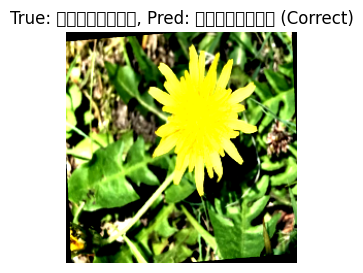

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from current font.
  fig.canvas.print_figure(

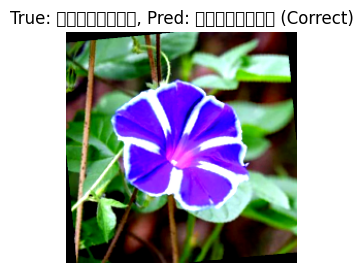

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figur

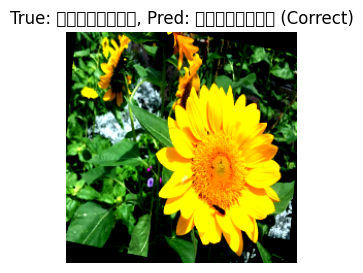

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from current font.
  fig.canvas.pri

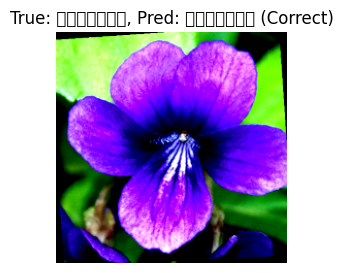

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


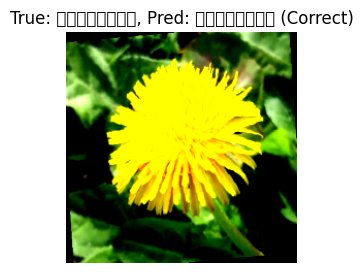

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


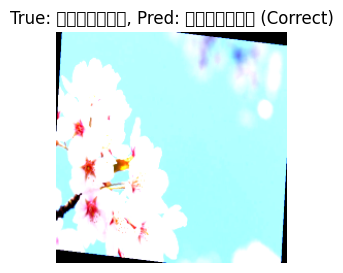

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


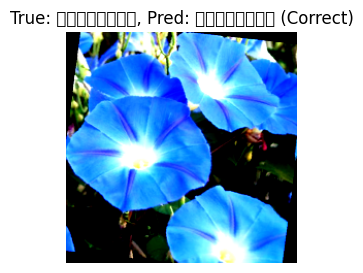

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


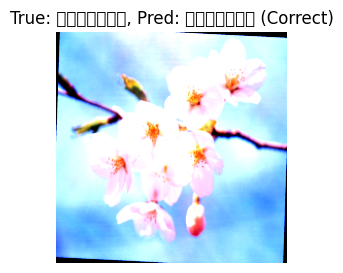

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


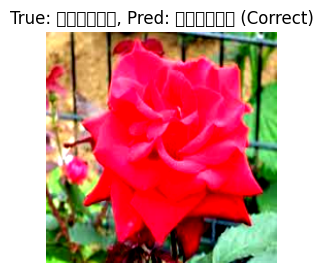

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


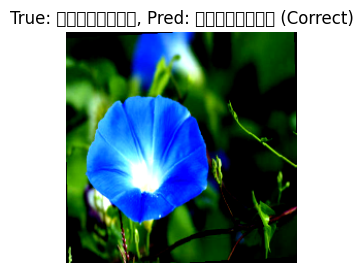

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


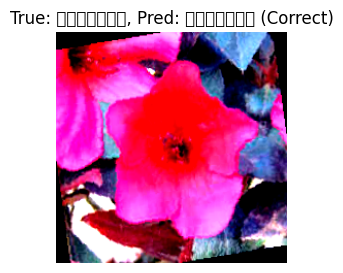

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


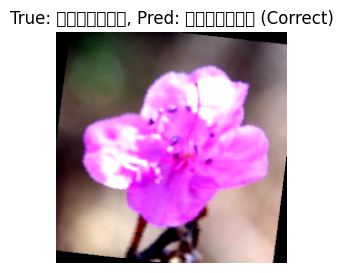

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


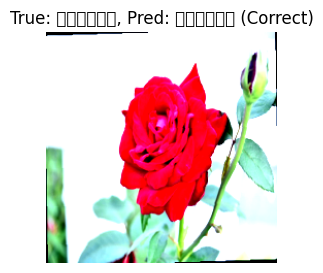

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


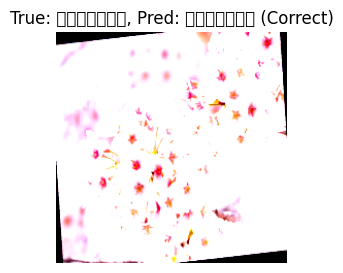

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


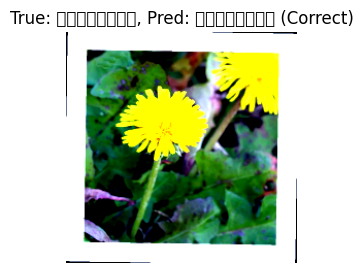

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


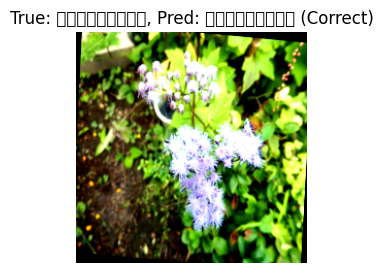

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


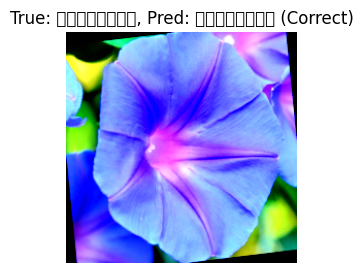

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


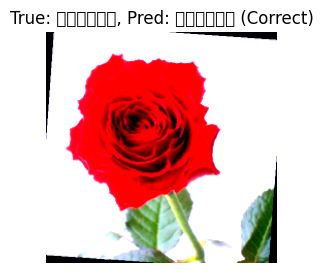

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


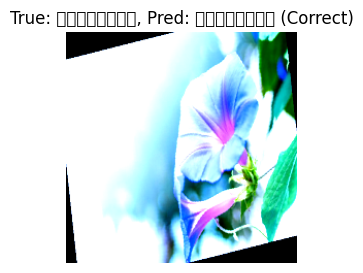

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


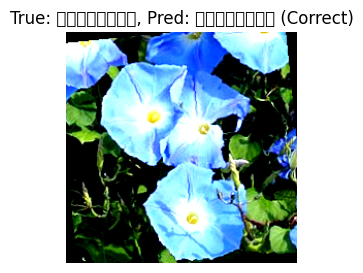

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


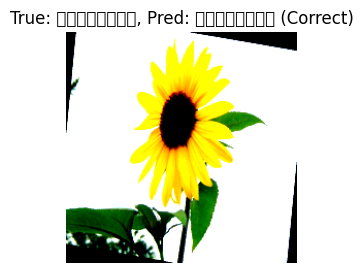

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nakajouhiroyuki/musashino/aidesign/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


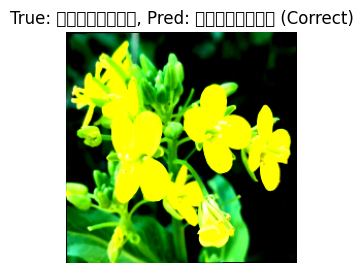

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


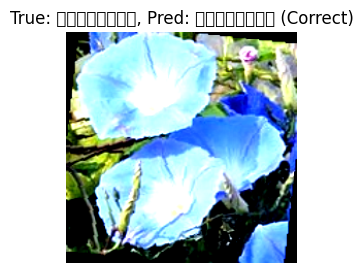

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


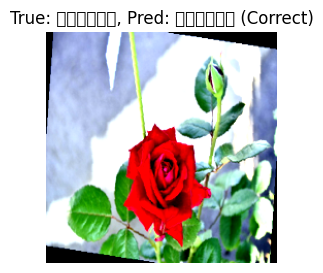

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


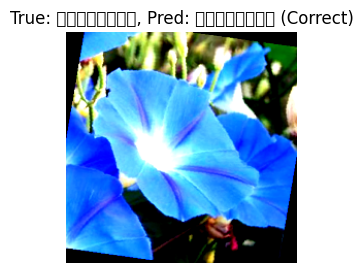

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


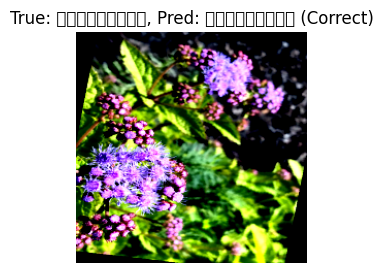

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


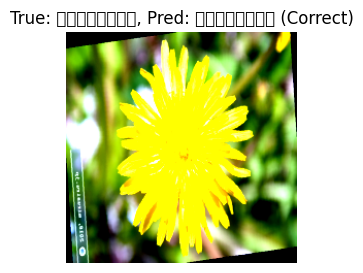

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


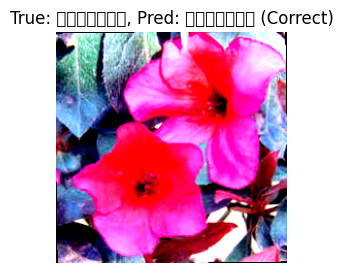

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


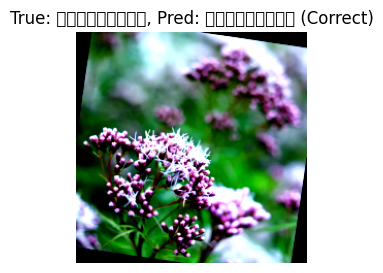

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


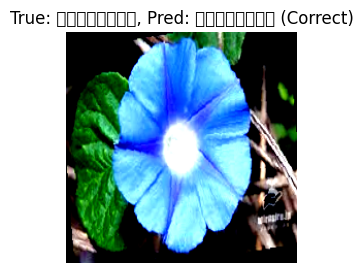

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


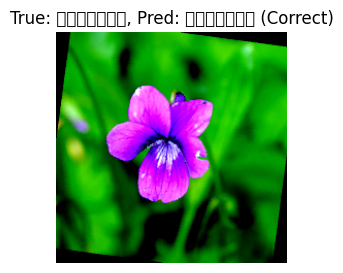

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


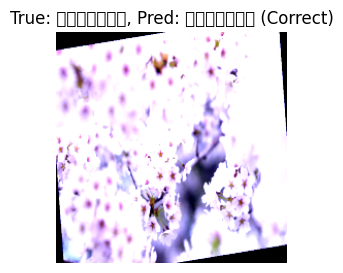

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


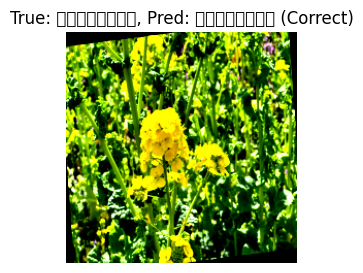

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


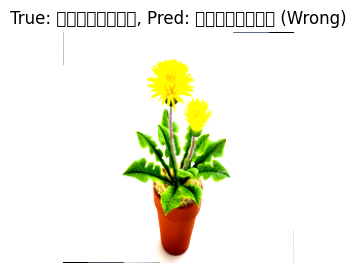

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


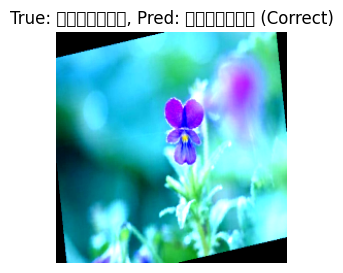

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


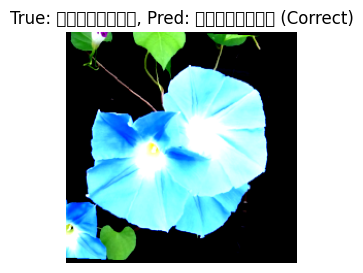

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


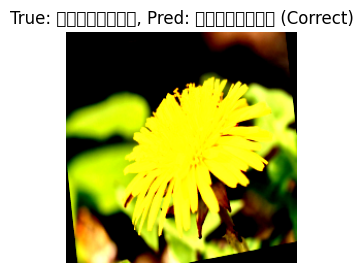

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


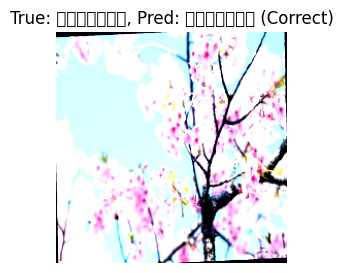

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


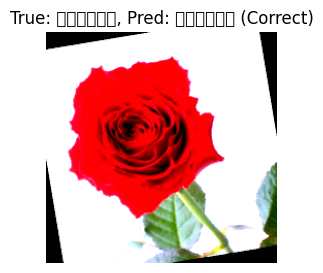

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


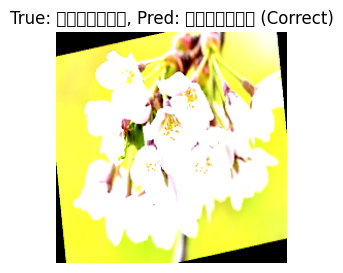

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


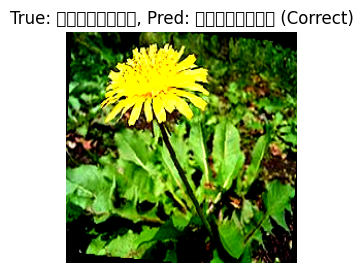

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


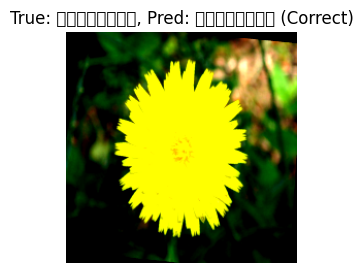

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


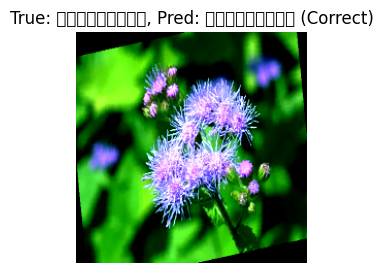

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


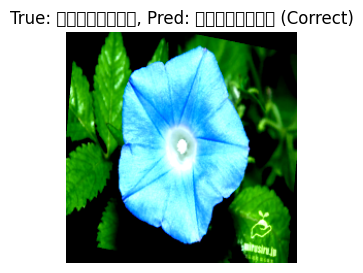

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


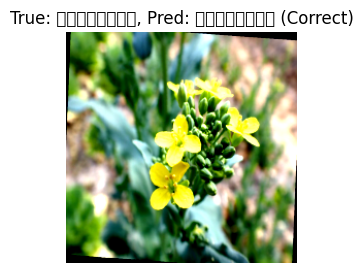

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


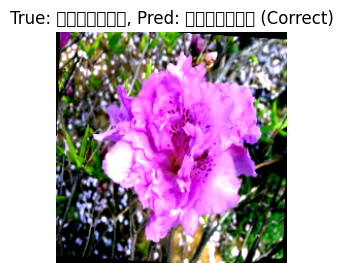

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


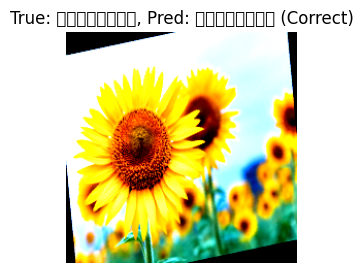

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


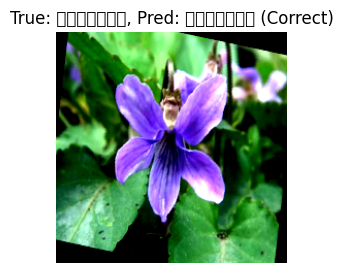

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


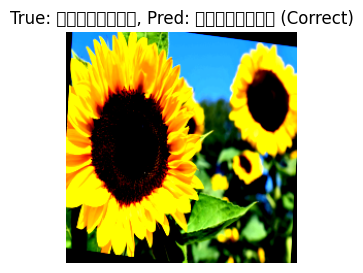

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


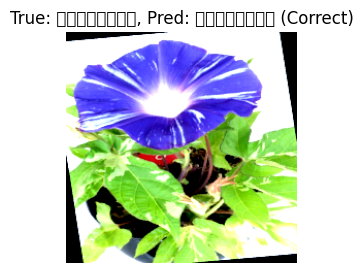

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


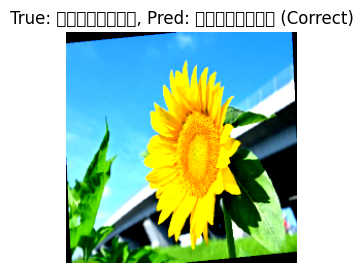

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


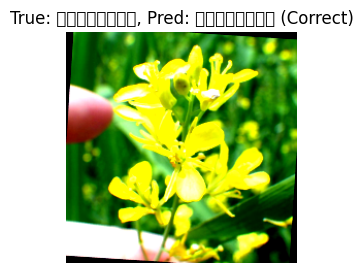

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


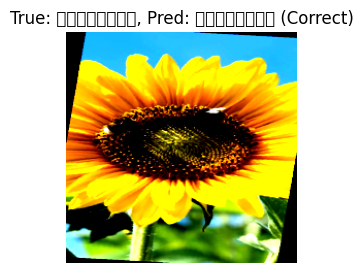

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


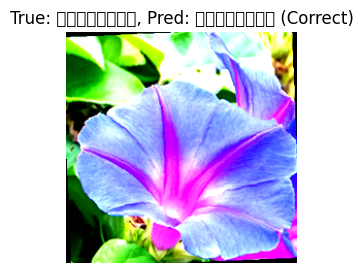

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


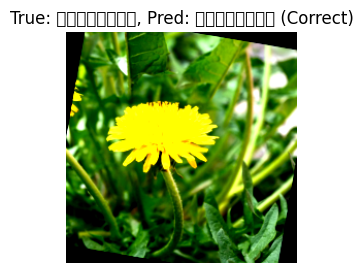

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


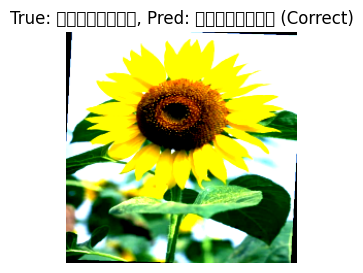

Accuracy on test set: 98.21428571428571%


In [30]:
# ブロック 12-2
import matplotlib.pyplot as plt
import numpy as np

# モデルを評価モードに設定。DropoutやBatchNormalizationなどの層が推論モードに切り替わる。
model.eval()
correct = 0  # 正しく分類されたサンプル数のカウントを初期化
total = 0    # テストデータのサンプルの総数を初期化

def imshow(img):
    # [0, 1]の範囲に変換
    img = img / 2 + 0.5
    npimg = img.numpy()  # PyTorchテンソルをnumpy配列に変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W)の順番を(H, W, C)に変更して表示
    plt.axis('off')  # 軸の目盛りを非表示にする

# 勾配の計算を停止。評価時には勾配計算が不要なため、メモリ効率と速度を向上させる。
with torch.no_grad():
    for inputs, labels in test_loader:  # テストデータローダからミニバッチ単位でデータを取得
        outputs = model(inputs.to(device))  # 入力をモデルに渡して、出力を取得
        _, predicted = torch.max(outputs.data, 1)  # 各サンプルの予測クラスのインデックスを取得
        total += labels.size(0)  # 現在のミニバッチのサンプル数をトータルカウントに追加
        correct += (predicted == labels.to(device)).sum().item()  # 正確に分類されたサンプル数をカウント
        
        # 推論結果の表示
        for i in range(inputs.size(0)):
            label = labels[i]          # 現在のサンプルの真のラベルを設定
            prediction = predicted[i]  # 現在のサンプルの予測ラベルを設定
            is_correct = "Correct" if label == prediction else "Wrong"  # 上の2つのラベルが一致するかどうかを評価
            
            plt.figure(figsize=(3,3))
            imshow(inputs[i])  # 画像を表示する関数を呼び出し
            plt.title(f"True: {dataset.classes[label]}, Pred: {dataset.classes[prediction]} ({is_correct})")  # タイトルに真のラベルと予測ラベルを表示
            plt.show()  # 画像とタイトルを表示

print(f"Accuracy on test set: {100 * correct / total}%")  # テストセットの全体での正解率を表示

In [31]:
model = model.to("mps") # 推論時にCPUで計算する場合は、重みを保存する前に、モデルをCPU用に変換しておく
# モデルの重みを保存
# torch.save(model.state_dict(), 'Weights/model3-2_mps.pth')